## ABOUT THE DATASET

This dataset records fare details and booking availability for a train journey. Key points include:

- **Fare Breakdown:**  
  - **Base Fare & Charges:** It lists the base fare along with additional charges such as reservation charge, service tax, and others (superfast, tatkal, catering, etc.).  
  - **Total Fare:** The sum of all these components represents the total fare for the journey.

- **Availability Details:**  
  - **Dynamic JSON Field:** The availability column contains a JSON-formatted list showing different travel dates with corresponding booking statuses (e.g., "PQWL17/WL10" indicates a pre-queue waiting list and waitlist numbers).

- **Train and Route Information:**  
  - **Train Number and Route:** It includes the train number and station codes for the departure and arrival stations.  
  - **Class Code:** The travel class is provided (for example, "2A" for second AC).

- **Timestamp:**  
  - **Record Time:** Each record includes a timestamp indicating when the data was recorded or queried.

The dataset provides a comprehensive SNAPSHOT of fare details, surcharges, and seat availability across multiple travel dates for a particular train route.

The code processes train journey availability data from a CSV file. It extracts waitlist information from a JSON-like availability column, computes additional details like the journey day and days remaining, and then restructures the data for easier analysis.

#### In our model, when a status indicates "AVAILABLE" (for example, "AVAILABLE-365"), we represent this as a negative waitlist value. That is, instead of using a positive number to denote availability, we store it as -365. This convention helps maintain a consistent approach where a positive number always indicates a waitlist count and a negative number indicates available seats.

In [ ]:
import pandas as pd
import ast
from datetime import datetime

def extract_waitlist_info(status_str):
    
    
    if '/' in status_str:
        parts = status_str.split('/')
        wl_parts = [p for p in parts if "WL" in p]
        if len(wl_parts) >= 2:
            part = wl_parts[1]  
        elif wl_parts:
            part = wl_parts[0]
        else:
            part = status_str
    else:
        part = status_str

    # Now handle AVAILABLE status
    if "AVAILABLE" in part.upper():
        
        try:
            num_str = part.split('-')[-1]
            
            return -int(num_str.lstrip("0") or "0")
        except Exception as e:
            return None
   
    if "WL" in part.upper():
        num_str = ''.join(filter(str.isdigit, part))
        if num_str:
            return int(num_str)
    return None

def process_availability(avail_str):
    try:
        avail_list = ast.literal_eval(avail_str)
    except Exception as e:
        return []
    
    processed = []
    for entry in avail_list:
        journey_date_str = entry.get('date')
        try:
            # Assuming format is "d-m-Y" e.g., "5-11-2023"
            journey_date = datetime.strptime(journey_date_str, "%d-%m-%Y")
        except Exception as e:
            journey_date = None
        day_of_week = journey_date.strftime("%A") if journey_date else None
        waitlist_num = extract_waitlist_info(entry.get('status', ''))
        processed.append({
            'journeyDate': journey_date,
            'dayOfWeek': day_of_week,
            'waitlist': waitlist_num
        })
    return processed

# Load CSV and parse timeStamp as datetime.
df = pd.read_csv("../Data/irctc/dynamic_coverage.csv", parse_dates=['timeStamp'])

# Process the availability column.
df['availability_parsed'] = df['availability'].apply(process_availability)

# Explode the availability_parsed column to get one row per availability record.
df_exploded = df.explode('availability_parsed')

# Expand the dictionary into separate columns.
df_exploded = pd.concat(
    [df_exploded.drop(columns=['availability_parsed']), 
     df_exploded['availability_parsed'].apply(pd.Series)],
    axis=1
)

# Calculate days remaining (journeyDate - timeStamp) in days.
# Ensure both columns are datetime.
df_exploded['daysRemaining'] = (df_exploded['journeyDate'] - df_exploded['timeStamp']).dt.days

# Display the resulting DataFrame columns of interest.
print(df_exploded[['trainNumber','classCode','fromStnCode','toStnCode' ,'journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining']])

# Optionally, save the processed data to a CSV.
df_exploded[['trainNumber', 'classCode','fromStnCode','toStnCode','journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining']].to_csv("processed_availability.csv", index=False)


       trainNumber classCode fromStnCode toStnCode journeyDate dayOfWeek  \
0             1027        2A          NK      CKTD  2023-11-05    Sunday   
0             1027        2A          NK      CKTD  2023-11-07   Tuesday   
0             1027        2A          NK      CKTD  2023-11-09  Thursday   
0             1027        2A          NK      CKTD  2023-11-11  Saturday   
0             1027        2A          NK      CKTD  2023-11-12    Sunday   
...            ...       ...         ...       ...         ...       ...   
30587        22420        3A          BE       ARJ  2024-01-09   Tuesday   
30587        22420        3A          BE       ARJ  2024-01-11  Thursday   
30587        22420        3A          BE       ARJ  2024-01-13  Saturday   
30587        22420        3A          BE       ARJ  2024-01-14    Sunday   
30587        22420        3A          BE       ARJ  2024-01-16   Tuesday   

       waitlist  daysRemaining  
0          10.0              4  
0          15.0      

In [42]:
df_exploded.head()

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,...,availability,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,journeyDate,dayOfWeek,waitlist,daysRemaining
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-05,Sunday,10.0,4
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-07,Tuesday,15.0,6
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-09,Thursday,26.0,8
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-11,Saturday,18.0,10
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,10.0,11


### Now we calculate the mean waitlist value by day of the week.

In [ ]:

# Assuming df_exploded is the DataFrame from the previous steps
# with columns: trainNumber, dayOfWeek, waitlist, etc.

# Group by 'trainNumber' and 'dayOfWeek' and calculate the mean waitlist value
mean_waitlist = df_exploded.groupby(['trainNumber', 'dayOfWeek'])['waitlist'].mean().reset_index()

# Optionally, sort the results for easier viewing:
mean_waitlist = mean_waitlist.sort_values(['trainNumber', 'dayOfWeek'])

print(mean_waitlist)

# Save the result to a CSV if desired:
mean_waitlist.to_csv("mean_waitlist_by_train_and_day.csv", index=False)


     trainNumber dayOfWeek   waitlist
0           1027    Friday  30.333333
1           1027    Monday  12.333333
2           1027  Saturday   0.125000
3           1027    Sunday   6.375000
4           1027  Thursday  -0.255319
..           ...       ...        ...
498        22404    Sunday -79.250000
499        22420  Saturday -21.179245
500        22420    Sunday -26.000000
501        22420  Thursday -21.019048
502        22420   Tuesday -26.321429

[503 rows x 3 columns]


In [44]:

# Read the CSV file with the mean waitlist values
df_mean = pd.read_csv("mean_waitlist_by_train_and_day.csv")

# Find the row with the maximum mean waitlist value
max_waitlist_row = df_mean.loc[df_mean['waitlist'].idxmax()]

# Find the row with the minimum mean waitlist value
min_waitlist_row = df_mean.loc[df_mean['waitlist'].idxmin()]

print("Row with maximum mean waitlist:")
print(max_waitlist_row)

print("\nRow with minimum mean waitlist:")
print(min_waitlist_row)


Row with maximum mean waitlist:
trainNumber         1439
dayOfWeek         Friday
waitlist       55.454545
Name: 9, dtype: object

Row with minimum mean waitlist:
trainNumber         22225
dayOfWeek         Tuesday
waitlist      -871.161765
Name: 489, dtype: object


In [45]:
import pandas as pd
import numpy as np

df=pd.read_csv("mean_waitlist_by_train_and_day.csv")

# -------------------------------------------------------------------
# 2. Map Days of the Week to Numeric (Monday = 0, Tuesday = 1, etc.)
# -------------------------------------------------------------------
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# Create a new column for the numeric day
df['dayIndex'] = df['dayOfWeek'].map(day_mapping)

# -------------------------------------------------------------------
# 3. Pivot the Data
# -------------------------------------------------------------------
# We want columns: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
# Pivot so each trainNumber is a row, and each dayOfWeek is a column with the mean waitlist
df_pivot = df.pivot_table(
    index='trainNumber',
    columns='dayOfWeek',
    values='waitlist',
    aggfunc='mean'   # If multiple rows exist for same train/day, take the average
).reset_index()

# Make sure columns are in the correct weekday order:
ordered_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_pivot = df_pivot[['trainNumber'] + [d for d in ordered_days if d in df_pivot.columns]]

# -------------------------------------------------------------------
# 4. Normalize the Waitlist for Each Day
# -------------------------------------------------------------------
# We can apply a simple min-max normalization for each day column individually.
# new_value = (value - min) / (max - min)

for day in ordered_days:
    if day in df_pivot.columns:
        col_min = df_pivot[day].min()
        col_max = df_pivot[day].max()
        # Avoid divide-by-zero if col_max == col_min
        if col_max != col_min:
            df_pivot[f"{day}_norm"] = (df_pivot[day] - col_min) / (col_max - col_min)
        else:
            # If all values are the same, just set them to 0.5 (or 0, etc.)
            df_pivot[f"{day}_norm"] = 0.5

# -------------------------------------------------------------------
# 5. Calculate a "Weekday Index" (Demand Pressure)
# -------------------------------------------------------------------
# For example, we can define a simple metric that sums the normalized waitlists
# across all days to get an overall "demand pressure" per train.
norm_columns = [f"{d}_norm" for d in ordered_days if f"{d}_norm" in df_pivot.columns]
df_pivot['weekdayIndex'] = df_pivot[norm_columns].sum(axis=1)

# -------------------------------------------------------------------
# 6. Display or Save Results
# -------------------------------------------------------------------
print("Pivoted and Normalized Data:\n", df_pivot)

# Optionally, save to CSV
df_pivot.to_csv("train_waitlist_weekday_pivoted.csv", index=False)


Pivoted and Normalized Data:
 dayOfWeek  trainNumber      Monday     Tuesday  Wednesday    Thursday  \
0                 1027   12.333333    1.312500  17.333333   -0.255319   
1                 1127         NaN  -60.200000        NaN         NaN   
2                 1435         NaN -180.665072        NaN         NaN   
3                 1439         NaN         NaN        NaN         NaN   
4                 1665         NaN         NaN        NaN   36.714286   
..                 ...         ...         ...        ...         ...   
120              22225 -863.235294 -871.161765        NaN -847.625000   
121              22324         NaN         NaN        NaN         NaN   
122              22388  -89.832353  -95.982353 -98.111765 -100.515625   
123              22404         NaN         NaN        NaN         NaN   
124              22420         NaN  -26.321429        NaN  -21.019048   

dayOfWeek      Friday    Saturday      Sunday  Monday_norm  Tuesday_norm  \
0           30.33

In [99]:
import pandas as pd

# Assuming df_exploded is your processed DataFrame containing:
#   - 'trainNumber' (e.g., 1027, 22420, etc.)
#   - 'dayOfWeek' (e.g. "Monday", "Tuesday", etc.)
#   - 'classCode' (e.g. "2A", "3A", "2S")
#   - 'waitlist' (numeric)

# 1. Group by trainNumber, dayOfWeek, and classCode; then compute mean waitlist.
df_train_day_class = (
    df_exploded
    .groupby(['trainNumber', 'dayOfWeek', 'classCode'], as_index=False)['waitlist']
    .mean()
)

# 2. Sort dayOfWeek in a logical order (Monday -> Sunday) if desired.
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_train_day_class['dayOfWeek'] = pd.Categorical(df_train_day_class['dayOfWeek'], 
                                                 categories=days_order, 
                                                 ordered=True)
df_train_day_class = df_train_day_class.sort_values(['trainNumber', 'dayOfWeek', 'classCode'])

print(df_train_day_class)

# 3. (Optional) Pivot if you want dayOfWeek as rows and classCode as columns,
# but still keep trainNumber as part of the index.
df_pivoted = df_train_day_class.pivot(
    index=['trainNumber','dayOfWeek'], 
    columns='classCode', 
    values='waitlist'
)

print(df_pivoted)

# 4. Save to CSV if desired
df_train_day_class.to_csv("mean_waitlist_by_train_day_class.csv", index=False)
df_pivoted.to_csv("mean_waitlist_pivot_train_day_class.csv")

df_pivoted.head(10)


      trainNumber dayOfWeek classCode   waitlist
3            1027    Monday        2A   3.500000
4            1027    Monday        3A   6.500000
5            1027    Monday        SL  27.000000
15           1027   Tuesday        2A   1.625000
16           1027   Tuesday        3A  -1.562500
...           ...       ...       ...        ...
1390        22420  Saturday        SL -62.625000
1391        22420    Sunday        1A -10.470588
1392        22420    Sunday        2A  -8.441176
1393        22420    Sunday        3A -31.481481
1394        22420    Sunday        SL -87.062500

[1403 rows x 4 columns]
classCode                     1A         2A  2S          3A  CC          SL
trainNumber dayOfWeek                                                      
1027        Monday           NaN   3.500000 NaN    6.500000 NaN   27.000000
            Tuesday          NaN   1.625000 NaN   -1.562500 NaN    3.875000
            Wednesday        NaN   5.000000 NaN   14.000000 NaN   33.000000
       

classCode               1A         2A  2S          3A  CC          SL
trainNumber dayOfWeek                                                
1027        Monday     NaN   3.500000 NaN    6.500000 NaN   27.000000
            Tuesday    NaN   1.625000 NaN   -1.562500 NaN    3.875000
            Wednesday  NaN   5.000000 NaN   14.000000 NaN   33.000000
            Thursday   NaN   2.812500 NaN   -6.133333 NaN    2.187500
            Friday     NaN  13.000000 NaN   18.000000 NaN   60.000000
            Saturday   NaN   1.750000 NaN   -4.500000 NaN    3.125000
            Sunday     NaN   2.125000 NaN    1.468750 NaN   15.531250
1127        Tuesday    NaN  -4.000000 NaN -102.100000 NaN  -74.500000
1435        Tuesday    NaN -22.291667 NaN  -26.523077 NaN -478.194444
1439        Friday     6.5  22.500000 NaN   33.166667 NaN  211.750000

/tmp/ipykernel_16658/2944367195.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_3A['dayOfWeek'] = pd.Categorical(df_1027_3A['dayOfWeek'], categories=days_order, ordered=True)


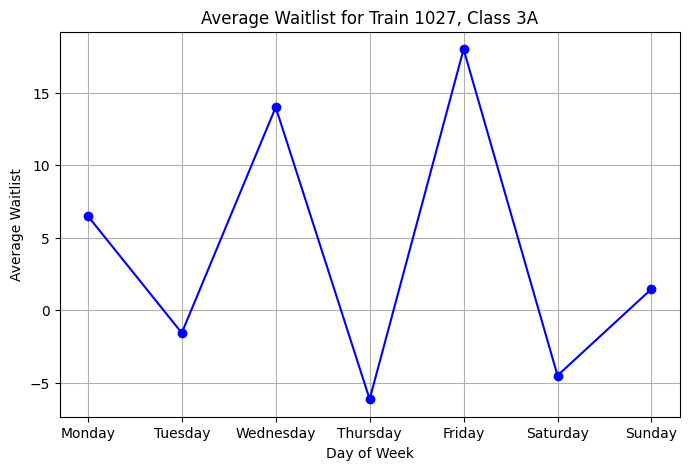

In [100]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_3A = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == '3A')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_3A['dayOfWeek'] = pd.Categorical(df_1027_3A['dayOfWeek'], categories=days_order, ordered=True)
df_1027_3A = df_1027_3A.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_3A['dayOfWeek'], df_1027_3A['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class 3A')
plt.grid(True)
plt.show()


/tmp/ipykernel_16658/30494720.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_2A_avg['dayOfWeek'] = pd.Categorical(df_1027_2A_avg['dayOfWeek'], categories=days_order, ordered=True)


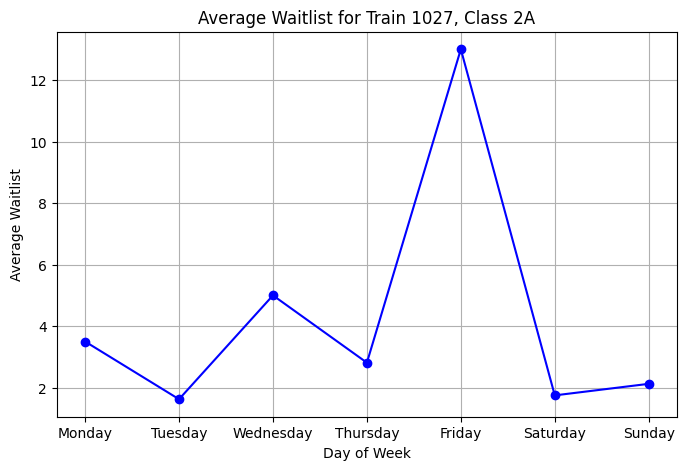

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_2A_avg = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == '2A')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_2A_avg['dayOfWeek'] = pd.Categorical(df_1027_2A_avg['dayOfWeek'], categories=days_order, ordered=True)
df_1027_2A_avg = df_1027_2A_avg.sort_values('dayOfWeek')
df__ = df_1027_2A_avg.copy()
df__= df__.set_index('dayOfWeek')
# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_2A_avg['dayOfWeek'], df_1027_2A_avg['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class 2A')
plt.grid(True)
plt.show()


/tmp/ipykernel_16658/1651065923.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1027_SL['dayOfWeek'] = pd.Categorical(df_1027_SL['dayOfWeek'], categories=days_order, ordered=True)


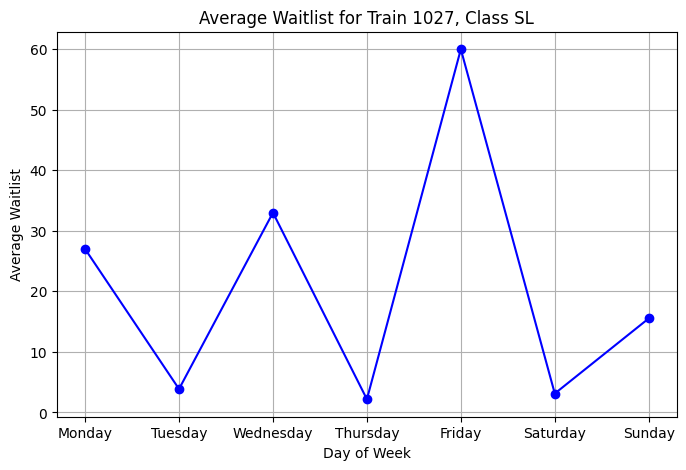

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_train_day_class is your DataFrame with columns:
# 'trainNumber', 'dayOfWeek', 'classCode', and 'waitlist' (mean waitlist values)

# Filter the data for train 1027 and class 3A
df_1027_SL = df_train_day_class[(df_train_day_class['trainNumber'] == 1027) &
                                (df_train_day_class['classCode'] == 'SL')]

# Order the days of the week properly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_1027_SL['dayOfWeek'] = pd.Categorical(df_1027_SL['dayOfWeek'], categories=days_order, ordered=True)
df_1027_SL = df_1027_SL.sort_values('dayOfWeek')

# Plot the chart
plt.figure(figsize=(8, 5))
plt.plot(df_1027_SL['dayOfWeek'], df_1027_SL['waitlist'], marker='o', linestyle='-', color='b')
plt.xlabel('Day of Week')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist for Train 1027, Class SL')
plt.grid(True)
plt.show()


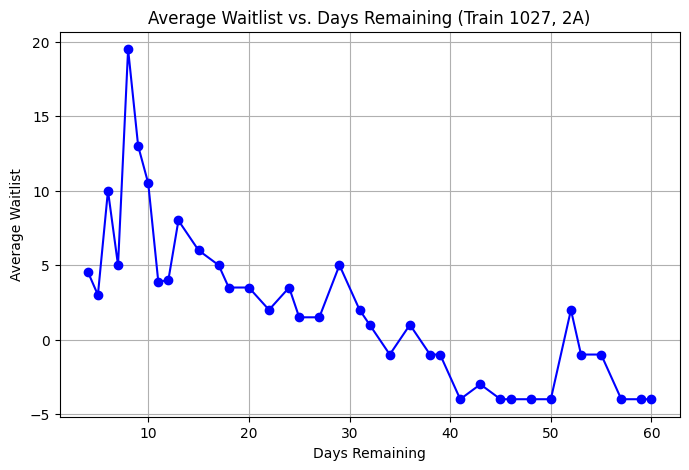

In [103]:


# 1. Filter the DataFrame for Train 1027, Class 2A
df_1027_2A = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == '2A')
]

# 2. Group by daysRemaining and compute the average waitlist
df_1027_2A_grouped = (
    df_1027_2A
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
)

# 3. Sort by daysRemaining so the x-axis is in ascending order
df_1027_2A_grouped = df_1027_2A_grouped.sort_values('daysRemaining')

# 4. Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(
    df_1027_2A_grouped['daysRemaining'],
    df_1027_2A_grouped['waitlist'],
    marker='o',
    linestyle='-',
    color='b'
)
plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, 2A)')
plt.grid(True)
plt.show()



In [104]:

# df_1027_2A['normalise']= df_1027_2A['waitlist']/(df__['waitlist'][df_1027_2A['dayOfWeek']])

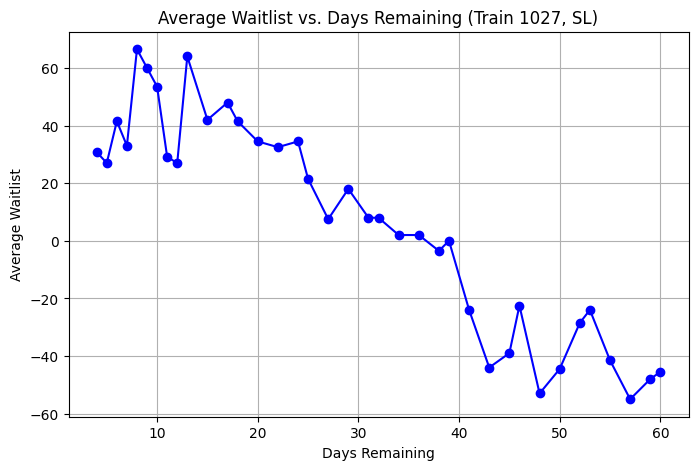

In [105]:


# 1. Filter the DataFrame for Train 1027, Class 2A
df_1027_SL = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == 'SL')
]

# 2. Group by daysRemaining and compute the average waitlist
df_1027_SL_grouped = (
    df_1027_SL
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
)

# 3. Sort by daysRemaining so the x-axis is in ascending order
df_1027_SL_grouped = df_1027_SL_grouped.sort_values('daysRemaining')

# 4. Plot the curve
plt.figure(figsize=(8, 5))
plt.plot(
    df_1027_SL_grouped['daysRemaining'],
    df_1027_SL_grouped['waitlist'],
    marker='o',
    linestyle='-',
    color='b'
)
plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, SL)')
plt.grid(True)
plt.show()



Local maxima (peaks) based on daysRemaining vs. avgWaitlist:
    daysRemaining  avgWaitlist
2               6         10.0
4               8         19.5
9              13          8.0
15             24          3.5
18             29          5.0
22             36          1.0
26             43         -3.0
31             52          2.0

Day-of-week breakdown for each peak dayRemaining:
   daysRemaining dayOfWeek  waitlist
0              6   Tuesday      10.0
1              8  Thursday      19.5
2             13   Tuesday       8.0
3             24  Saturday       3.5
4             29  Thursday       5.0
5             36  Thursday       1.0
6             43  Thursday      -3.0
7             52  Saturday       2.0


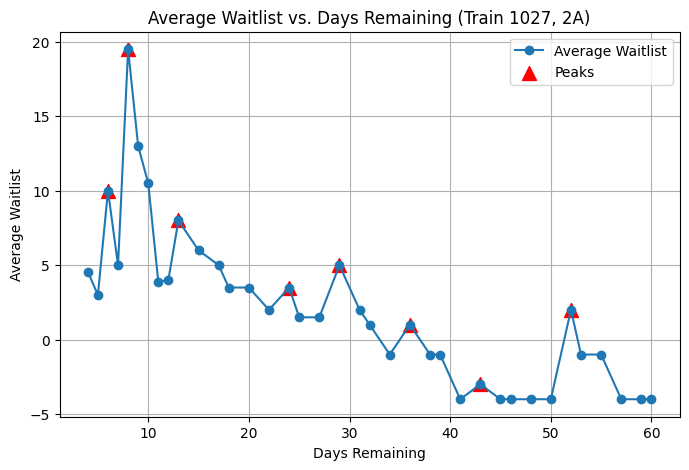

In [106]:

# -------------------------------------------------
# 1. FILTER FOR TRAIN 1027, CLASS 2A
# -------------------------------------------------
df_1027_2A = df_exploded[
    (df_exploded['trainNumber'] == 1027) &
    (df_exploded['classCode'] == '2A')
].copy()

# -------------------------------------------------
# 2. GROUP BY daysRemaining AND COMPUTE AVERAGE WAITLIST
# -------------------------------------------------
df_avg = (
    df_1027_2A
    .groupby('daysRemaining', as_index=False)['waitlist']
    .mean()
    .rename(columns={'waitlist': 'avgWaitlist'})
    .sort_values('daysRemaining')
)

# -------------------------------------------------
# 3. IDENTIFY LOCAL MAXIMA (PEAKS)
# -------------------------------------------------
# Shift the avgWaitlist column to compare each row with its previous and next
df_avg['prev'] = df_avg['avgWaitlist'].shift(1)
df_avg['next'] = df_avg['avgWaitlist'].shift(-1)

# A local max if avgWaitlist is greater than both neighbors
df_avg['is_peak'] = (
    (df_avg['avgWaitlist'] > df_avg['prev']) &
    (df_avg['avgWaitlist'] > df_avg['next'])
)

# Filter rows that are peaks
peaks = df_avg[df_avg['is_peak']].copy()
peak_days = peaks['daysRemaining'].unique()

print("Local maxima (peaks) based on daysRemaining vs. avgWaitlist:")
print(peaks[['daysRemaining', 'avgWaitlist']])

# -------------------------------------------------
# 4. MAP PEAKS BACK TO ORIGINAL DATA TO SEE dayOfWeek
# -------------------------------------------------
# Filter the original data for these peak days
df_peak_contributors = df_1027_2A[df_1027_2A['daysRemaining'].isin(peak_days)]

# For each peak dayRemaining, see which dayOfWeek values contributed
df_peak_dayofweek = (
    df_peak_contributors
    .groupby(['daysRemaining', 'dayOfWeek'], as_index=False)['waitlist']
    .mean()
    .sort_values(['daysRemaining', 'waitlist'], ascending=[True, False])
)

print("\nDay-of-week breakdown for each peak dayRemaining:")
print(df_peak_dayofweek)

# -------------------------------------------------
# 5. OPTIONAL: PLOT THE avgWaitlist vs. daysRemaining CURVE WITH PEAKS
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(df_avg['daysRemaining'], df_avg['avgWaitlist'], marker='o', linestyle='-', label='Average Waitlist')

# Highlight the peaks in a different color/marker
plt.scatter(peaks['daysRemaining'], peaks['avgWaitlist'], color='red', marker='^', s=100, label='Peaks')

plt.xlabel('Days Remaining')
plt.ylabel('Average Waitlist')
plt.title('Average Waitlist vs. Days Remaining (Train 1027, 2A)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
print(df_avg.head())

   daysRemaining  avgWaitlist       prev  next  is_peak
0              4     4.555556        NaN   3.0    False
1              5     3.000000   4.555556  10.0    False
2              6    10.000000   3.000000   5.0     True
3              7     5.000000  10.000000  19.5    False
4              8    19.500000   5.000000  13.0     True


In [108]:

# Example df_peak_dayofweek structure:
#    daysRemaining  dayOfWeek  waitlist
# 0             6    Tuesday      10.0
# 1             8   Thursday      19.5
# 2            13    Tuesday       8.0
# 3            24  Saturday       3.5                                                                                                                                                                   
# 4            29  Thursday       5.0
# 5            36  Thursday       1.0
# 6            43  Thursday      -3.0
# 7            52  Saturday       2.0

# 1. Group by dayOfWeek and compute mean waitlist among these peak rows
peak_ranking = (
    df_peak_dayofweek
    .groupby('dayOfWeek', as_index=False)['waitlist']
    .mean()
    .rename(columns={'waitlist': 'avgWaitlist'})
    .sort_values('avgWaitlist', ascending=False)
)

# 2. Assign a rank (1 = highest average waitlist)
peak_ranking['rank'] = peak_ranking['avgWaitlist'].rank(method='dense', ascending=False)

print("Day-of-week ranking based on average peak waitlist:")
print(peak_ranking)


Day-of-week ranking based on average peak waitlist:
  dayOfWeek  avgWaitlist  rank
2   Tuesday        9.000   1.0
1  Thursday        5.625   2.0
0  Saturday        2.750   3.0


In [109]:
print(df_exploded['waitlist'].min())

-1714.0


In [110]:
print(df_exploded.columns)

Index(['baseFare', 'reservationCharge', 'superfastCharge', 'fuelAmount',
       'totalConcession', 'tatkalFare', 'serviceTax', 'otherCharge',
       'cateringCharge', 'dynamicFare', 'totalFare', 'availability',
       'trainNumber', 'fromStnCode', 'toStnCode', 'classCode', 'timeStamp',
       'journeyDate', 'dayOfWeek', 'waitlist', 'daysRemaining'],
      dtype='object')


In [111]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Columns of interest
columns_of_interest = ['trainNumber', 'classCode', 'daysRemaining', 'dayOfWeek', 'fromStnCode', 'toStnCode', 'waitlist']

# Select relevant columns (ensure df_exploded exists)
df_subset = df_exploded[columns_of_interest].copy()  # Work on a copy to avoid warnings

# Encode string columns using LabelEncoder
label_encoders = {}
for col in ['classCode', 'fromStnCode', 'toStnCode','dayOfWeek']:
    le = LabelEncoder()
    df_subset[col] = le.fit_transform(df_subset[col].astype(str))  # Convert to string if necessary
    label_encoders[col] = le  # Save encoders for potential reuse

# Compute the correlation matrix
correlation_matrix = df_subset.corr()

# Print the correlation matrix
print(correlation_matrix)


               trainNumber  classCode  daysRemaining  dayOfWeek  fromStnCode  \
trainNumber       1.000000  -0.071821       0.051077  -0.016086     0.048967   
classCode        -0.071821   1.000000      -0.001803  -0.001405     0.040598   
daysRemaining     0.051077  -0.001803       1.000000   0.013515     0.005409   
dayOfWeek        -0.016086  -0.001405       0.013515   1.000000    -0.003877   
fromStnCode       0.048967   0.040598       0.005409  -0.003877     1.000000   
toStnCode         0.137543   0.013883       0.007384  -0.013197     0.057704   
waitlist         -0.038569  -0.196151      -0.110480  -0.004005    -0.035302   

               toStnCode  waitlist  
trainNumber     0.137543 -0.038569  
classCode       0.013883 -0.196151  
daysRemaining   0.007384 -0.110480  
dayOfWeek      -0.013197 -0.004005  
fromStnCode     0.057704 -0.035302  
toStnCode       1.000000 -0.057859  
waitlist       -0.057859  1.000000  


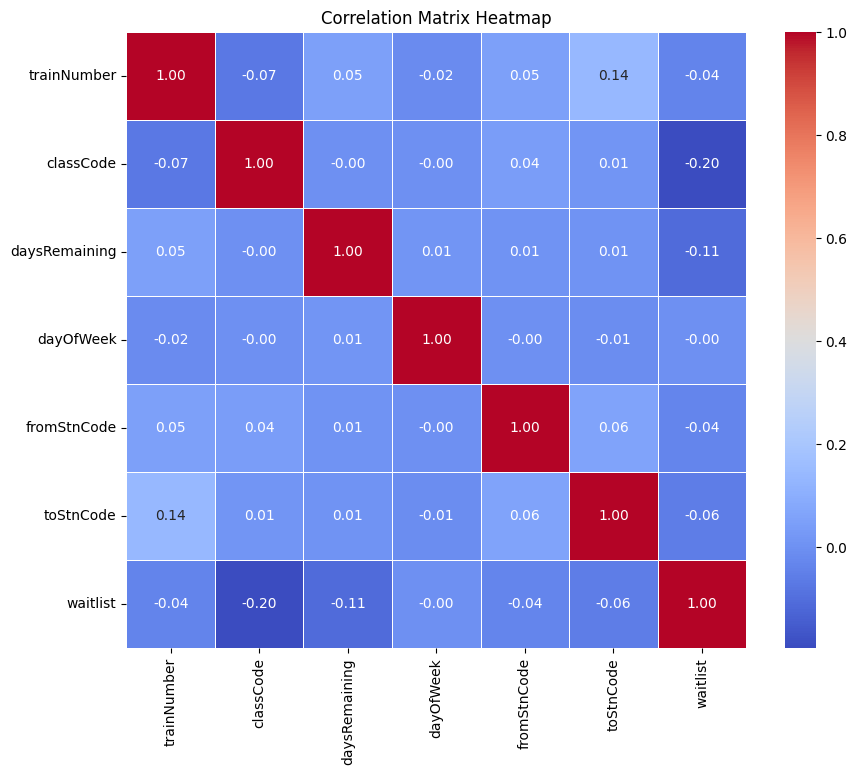

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the heatmap
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [113]:
df_exploded.head()

,baseFare,reservationCharge,superfastCharge,fuelAmount,totalConcession,tatkalFare,serviceTax,otherCharge,cateringCharge,dynamicFare,...,availability,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,journeyDate,dayOfWeek,waitlist,daysRemaining
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-05,Sunday,10.0,4
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-07,Tuesday,15.0,6
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-09,Thursday,26.0,8
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-11,Saturday,18.0,10
0,2350,50,0,0.0,0,0,120.0,0,0,0,...,"[{'date': '5-11-2023', 'status': 'PQWL17/WL10'...",1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,10.0,11


In [116]:
df_exploded.drop(columns=['baseFare', 'reservationCharge','superfastCharge','fuelAmount', 'totalConcession','tatkalFare', 'serviceTax', 'otherCharge' , 'cateringCharge', 'dynamicFare', 'totalFare',  'availability' ], inplace=True)

In [127]:
df_exploded.reset_index(drop=True, inplace=True)
print(df_exploded['waitlist'].isna().sum())
print(df_exploded.isna().sum().sum())
df_exploded.dropna(inplace=True)
df_exploded


8018
58541


,trainNumber,fromStnCode,toStnCode,classCode,timeStamp,journeyDate,dayOfWeek,waitlist,daysRemaining,isWeekend,demand_pressure,dayOfWeekNum,demand_zone
0,1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-05,Sunday,10.0,4,1,0.384615,6,peak
1,1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-07,Tuesday,15.0,6,0,0.576923,1,peak
2,1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-09,Thursday,26.0,8,0,1.000000,3,peak
3,1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-11,Saturday,18.0,10,1,0.692308,5,peak
4,1027,NK,CKTD,2A,2023-10-31 19:25:08.643266,2023-11-12,Sunday,10.0,11,1,0.384615,6,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175345,22420,BE,ARJ,3A,2023-10-31 20:43:44.098136,2024-01-09,Tuesday,-6.0,69,0,-0.052632,1,advance
175346,22420,BE,ARJ,3A,2023-10-31 20:43:44.098136,2024-01-11,Thursday,-6.0,71,0,-0.052632,3,advance
175347,22420,BE,ARJ,3A,2023-10-31 20:43:44.098136,2024-01-13,Saturday,-6.0,73,1,-0.052632,5,advance
175348,22420,BE,ARJ,3A,2023-10-31 20:43:44.098136,2024-01-14,Sunday,-5.0,74,1,-0.043860,6,advance


In [128]:
# Convert dates to datetime objects
df_exploded['timeStamp'] = pd.to_datetime(df_exploded['timeStamp'])
df_exploded['journeyDate'] = pd.to_datetime(df_exploded['journeyDate'])

# Calculate booking lead time (days remaining)
df_exploded['daysRemaining'] = (df_exploded['journeyDate'] - df_exploded['timeStamp']).dt.days

# Add a binary feature for weekends
df_exploded['isWeekend'] = df_exploded['dayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

# Create demand pressure feature
df_exploded['demand_pressure'] = df_exploded['waitlist'] / df_exploded.groupby(['trainNumber', 'classCode'])['waitlist'].transform('max')

# Encode day of the week numerically
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df_exploded['dayOfWeekNum'] = df_exploded['dayOfWeek'].map(day_mapping)

# Define demand zones based on days remaining
bins = [0, 10, 20, 30, 60, 90]
labels = ['peak', 'high', 'medium', 'low', 'advance']
df_exploded['demand_zone'] = pd.cut(df_exploded['daysRemaining'], bins=bins, labels=labels)


In [129]:
from sklearn.model_selection import train_test_split

# Select relevant features for modeling
features = ['daysRemaining', 'dayOfWeekNum', 'isWeekend', 'demand_pressure']
X = df_exploded[features]
y = df_exploded['waitlist']
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)




In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.2f}")


Root Mean Squared Error: 34.56


In [137]:
print(y_pred, y_test)

0          5.000000
1        -18.000000
2       -202.000000
3        -20.120000
4        -17.750000
            ...    
31532    -18.000000
31533    -50.000000
31534      1.790898
31535      8.060000
31536      4.475000
Length: 31537, dtype: float64 89084       5.0
146465    -18.0
109390   -202.0
26620     -19.0
165047    -19.0
          ...  
147420    -18.0
12696     -50.0
84544       7.0
96062       8.0
31050       3.0
Name: waitlist, Length: 31537, dtype: float64


In [138]:
def calculate_dynamic_price(base_price, predicted_waitlist):
    """
    Adjust price dynamically based on predicted waitlist.
    """
    if predicted_waitlist > 20:  # High demand
        return base_price * 1.25  # Increase by 25%
    elif predicted_waitlist > 10:  # Medium demand
        return base_price * 1.10  # Increase by 10%
    elif predicted_waitlist < -5:  # Low demand (negative waitlist means availability)
        return base_price * 0.85  # Discount by 15%
    else:
        return base_price

# Apply dynamic pricing to the dataset
df_exploded['predicted_waitlist'] = model.predict(df_exploded[features])
df_exploded['dynamic_price'] = df_exploded.apply(
    lambda row: calculate_dynamic_price(base_price=2000, predicted_waitlist=row['predicted_waitlist']),
    axis=1
)


In [139]:
# Calculate revenue with dynamic pricing
df_exploded['revenue_dynamic'] = df_exploded['dynamic_price'] * (df_exploded['waitlist'].clip(lower=0))

# Calculate baseline revenue (assume fixed price of ₹2000)
df_exploded['revenue_baseline'] = 2000 * (df_exploded['waitlist'].clip(lower=0))

# Compare revenues
total_revenue_dynamic = df_exploded['revenue_dynamic'].sum()
total_revenue_baseline = df_exploded['revenue_baseline'].sum()
revenue_lift = (total_revenue_dynamic - total_revenue_baseline) / total_revenue_baseline * 100

print(f"Baseline Revenue: ₹{total_revenue_baseline:.2f}")
print(f"Dynamic Pricing Revenue: ₹{total_revenue_dynamic:.2f}")
print(f"Revenue Lift: {revenue_lift:.2f}%")


Baseline Revenue: ₹979124000.00
Dynamic Pricing Revenue: ₹1166676800.00
Revenue Lift: 19.16%
